In [1]:
from torch import nn
import torch

In [2]:
from PIL import Image as im
import torchvision
import os
to_tensor = torchvision.transforms.ToTensor()
xl = to_tensor(im.open(os.path.join('../data/segmentations_with_erosion_all', 'Case00_segmentation_21.jpg')))
yl = to_tensor(im.open(os.path.join('../data/segmentations_with_erosion_all', 'Case02_segmentation_32.jpg')))

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

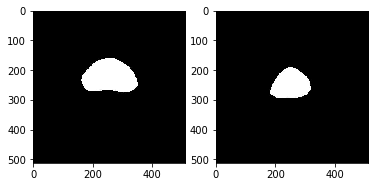

In [4]:
plt.subplot(1,2,1)
plt.imshow(xl[0].detach(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(yl[0].detach(), cmap='gray')

## Constructing an edge map

We want to weight the output of the segmentation method in such a way that areas around the edges of the segmentation are weighted heavier. The approach here is to first do a simple edge detection. We (probably) want to blur the the resulting map to also make areas near, but not on an edge weighted a more than areas not near a border at all.

Construction of the Gaussian kernel is not written in Torch as we don't need to calculate any gradient of this process. 

Two methods are implemented for combining horizontal and vertical edges. One is taking the sum of the abs while the other is taking the square root of the sum of the squares. Below I try to see what are the differences in the resulting weight maps. It seems the differences between the two are negligible.

In [55]:
from scipy import stats as st
from skimage.morphology import dilation, erosion

def edges(x):
    xx = torch.zeros_like(x)
    xy = torch.zeros_like(x)
    xx[:,:-1,:] = x[:,1:, :] - x[:,:-1, :]
    xy[:,:,:-1] = x[:,:, 1:] - x[:,:, :-1]
    return xx, xy

def all_edges(x):
    xx, xy = edges(x)
    return torch.sqrt((xx * xx) + (xy * xy))

def all_edges_abs(x):
    xx, xy = edges(x)    
    return torch.abs(xx) + torch.abs(xy)

def all_edges_dilate_erode(tensor_x):
    x = tensor_x.view(512,512).detach().numpy()
    dilated = dilation(x)
    eroded = erosion(x)
    return torch.tensor([[dilated - eroded]])

def gkern(kernlen=5, nsig=3):
    """Returns a 2D Gaussian kernel array. Taken from https://stackoverflow.com/a/29731818"""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return np.array(kernel, dtype=np.float)

from torch.nn import Conv2d
from scipy.ndimage.filters import gaussian_filter
conv = Conv2d(1,1,15, padding=7)

def smoothed_edges(x):
    xcombined = all_edges(x).view([1,1,512,512])
    return smooth(xcombined)
    
def smooth(im):
    array = [[gkern(15)]]
    kernel = torch.tensor(array, dtype=torch.float)
    conv.weight = torch.nn.Parameter(data=kernel)
    return conv.forward(im)

def smoothed_edges_abs(x):
    xcombined = all_edges_abs(x).view([1,1,512,512])
    return smooth(xcombined)

## Jpeg artifacts
I first tried to load the segmentations as jpegs but ran into trouble caused by jpeg artifacts. Because of them, it was impossible (or hard at least) to analyse the methods well.

In [6]:
import numpy as np

def describe(im, name=None):
    if name is not None:
        print(name)
    print('shape:',im.shape)
    print('min:', np.min(im))
    print('max', np.max(im))
    print('mean', np.mean(im))

im1
shape: (150, 200)
min: -1.0
max 1.0
mean 0.0
im2
shape: (150, 200)
min: -1.0
max 1.0
mean 0.00073333335


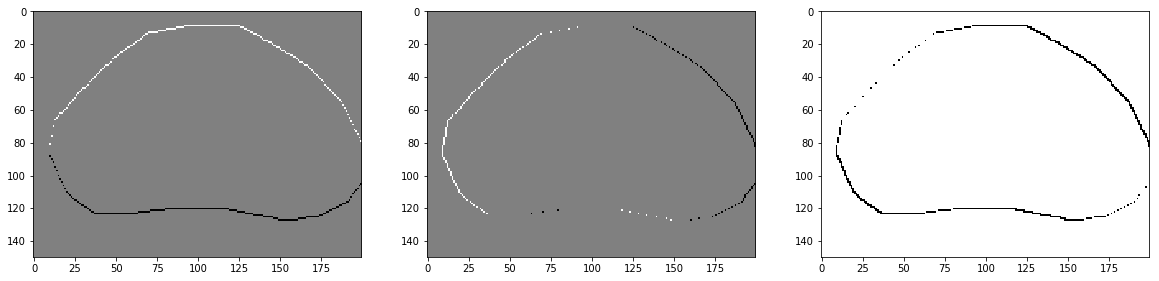

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
im1 = edges(xl)[0].view(512,512).detach().numpy()[150:300,150:350]
describe(im1, name='im1')
plt.imshow(im1, cmap='gray', vmin=-1, vmax=1)

plt.subplot(1,3,2)
im2 = edges(xl)[1].view(512,512).detach().numpy()[150:300,150:350]
describe(im2, name='im2')
plt.imshow(im2, cmap='gray', vmin=-1, vmax=1)


plt.subplot(1,3,3)
mask = im1 == im2
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

# plt.figure()
# plt.hist(im1.flatten())
# plt.figure()
# plt.hist(im2.flatten())

From here on, I'm working with segmentation loaded from the raw data. In the plots below we see there are no artifacts anymore.

In [8]:
import skimage.io as io
def imload(file_path):
    img = io.imread(os.path.join(file_path), plugin='simpleitk')
    img = img.astype(np.float32)
    img /= img.max()
    return img

torch.Size([1, 512, 512])
im1
shape: (150, 200)
min: 0.0
max 1.4142135
mean 0.018476956
im2
shape: (150, 200)
min: 0.0
max 2.0
mean 0.02


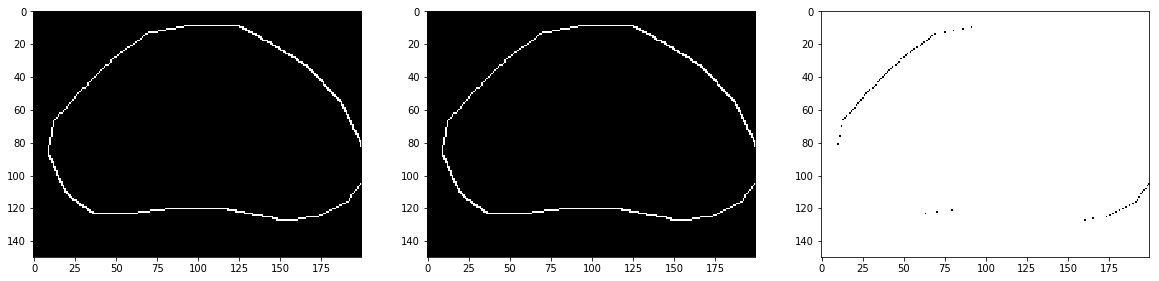

In [26]:
data_folder = '../data/raw_data/'
segmentation_file_name = 'Case{}_segmentation.mhd'
xl = torch.from_numpy(imload(os.path.join(data_folder,segmentation_file_name.format('00'))))[21:22]
print(xl.shape)


plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
im1 = all_edges(xl).view(512,512).detach().numpy()[150:300,150:350]
describe(im1, name='im1')
plt.imshow(im1, cmap='gray', vmin=0, vmax=1)

plt.subplot(1,3,2)
im2 = all_edges_abs(xl).view(512,512).detach().numpy()[150:300,150:350]
describe(im2, name='im2')
plt.imshow(im2, cmap='gray', vmin=0, vmax=1)

plt.subplot(1,3,3)
mask = im1 ==im2
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

## Comparing two edge combination methods

Below the effects of the two implementations for combining horizontal and vertical edges are shown. They look the same to me. Based on these images we could choose either one to work with. 

On the right, the difference between the two results are shown. Apparently there is some difference between the two methods for edges that are a bit in the direction of y=x. I don't see why this is the case yet. The effect seems quite small though so maybe we shouldn't care too much about it.

im1
shape: (150, 200)
min: -0.055496242
max 0.12086427
mean -0.036912482
im2
shape: (150, 200)
min: -0.055496242
max 0.12316728
mean -0.035394557


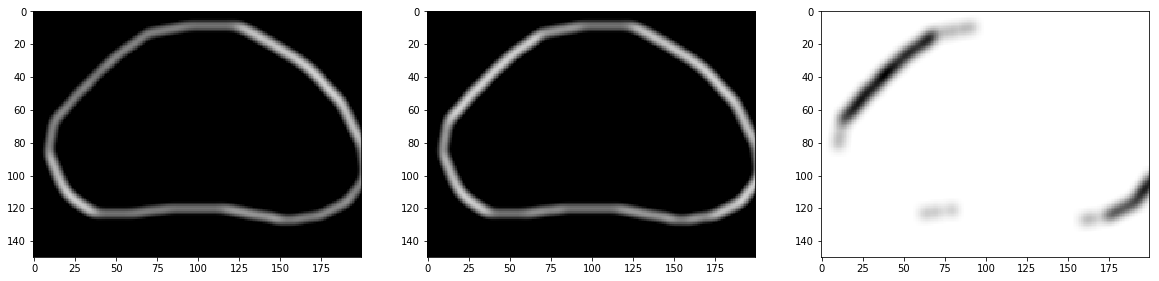

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
im1 = smoothed_edges(xl).view(512,512).detach().numpy()[150:300,150:350]
describe(im1, name='im1')
plt.imshow(im1, cmap='gray', vmin=0, vmax=0.15)

plt.subplot(1,3,2)
im2 = smoothed_edges_abs(xl).view(512,512).detach().numpy()[150:300,150:350]
describe(im2, name='im2')
plt.imshow(im2, cmap='gray', vmin=0, vmax=0.15)

plt.subplot(1,3,3)
mask = im1 - im2
plt.imshow(mask, cmap='gray')

In [11]:
np.sqrt(257049)

507.0

torch.Size([1, 512, 512])
im1
shape: (150, 200)
min: 0.051943593
max 0.29340407
mean 0.08046466
im2
shape: (150, 200)
min: 0.051943593
max 0.29340407
mean 0.08046466


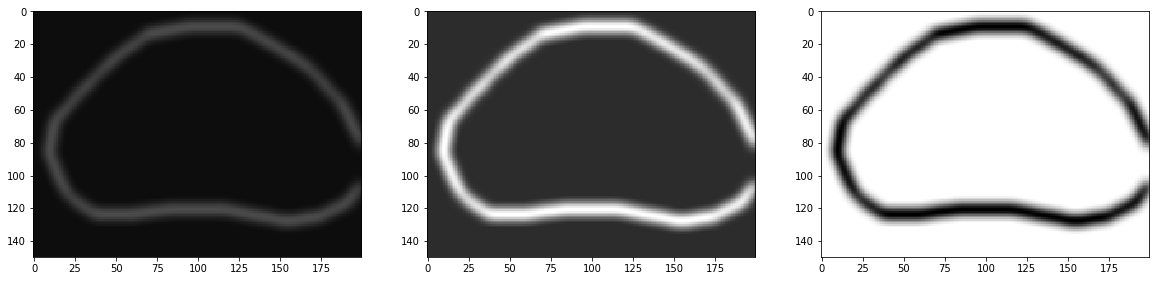

In [67]:
def edge_dilate_smooth(xl, dilate_steps, label, edge_method = 'sqrt'):
    if edge_method is 'abs':
        im = all_edges_abs(xl).view(512,512)
    elif edge_method is 'sqrt':
        im = all_edges(xl).view(512,512)
    elif edge_method is 'dilate_erode':
        im = all_edges_dilate_erode(xl).view(512,512)
        
    im = im.detach().numpy()[150:300,150:350]

    for i in range(dilate_steps):
        im = dilation(im)
    im = torch.tensor([[im]], dtype=torch.float)
    im = smooth(im).view(150,200).detach().numpy()
    describe(im, name=label)
    return im
    
data_folder = '../data/raw_data/'
segmentation_file_name = 'Case{}_segmentation.mhd'
xl = torch.from_numpy(imload(os.path.join(data_folder,segmentation_file_name.format('00'))))[21:22]
print(xl.shape)


plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
im1 = edge_dilate_smooth(xl, 0, 'im1', edge_method='dilate_erode')
plt.imshow(im1, cmap='gray', vmin=0, vmax=1)

plt.subplot(1,3,2)
im2 = edge_dilate_smooth(xl, 0, 'im2', edge_method='dilate_erode')
im2 = im2 / np.max(im2)
plt.imshow(im2, cmap='gray', vmin=0, vmax=1)

plt.subplot(1,3,3)
mask = im1 - im2
plt.imshow(mask, cmap='gray')